In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# select the style from fivethityeight website
mpl.rcdefaults() 
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

# predefined figsize
figsize=(12,9)

np.random.seed(238746)

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
sales = pd.read_csv('train.csv', parse_dates=[0], index_col=0)

In [3]:
#fix date
date=[]
k=0
for i in sales.index:
    date.append(i.split('WE ')[1])
    k+=1
sales.index=date
sales['datetime']=sales.index
sales['datetime']=pd.to_datetime(sales['datetime'])
sales=sales.sort_values(['datetime','sku'])
#remove outliers(sku =1608)
sales=sales[sales.sku!=1608]
sales['week'] = pd.Categorical(sales.datetime)
sales['week']=sales.week.cat.codes
melt = sales.sort_values(['week', 'sku'])
melt_p=melt[['sku','week','target','price','sales w-1']]
melt_p['sales w-2']=melt_p.groupby(['sku'])['sales w-1'].shift()
melt_p['sales w-3']=melt_p.groupby(['sku'])['sales w-2'].shift()
melt_p['sales w-4']=melt_p.groupby(['sku'])['sales w-3'].shift()

melt_p['w-1 diff']=melt_p['sales w-1']-melt_p['sales w-2']
melt_p['w-2 diff']=melt_p['sales w-2']-melt_p['sales w-3']
melt_p['w-3 diff']=melt_p['sales w-3']-melt_p['sales w-4']
#melt_p['sales w-3 diff']=melt_p.groupby(['sku'])['sales w-3'].diff()
melt_p=melt_p.dropna()

In [4]:
melt_p=melt_p[['sku','week','target','price','sales w-1','sales w-3','w-1 diff','w-3 diff']]

In [5]:
melt_p#melt[melt.week==107]#['sales w-2_real'][31:]

,sku,week,target,price,sales w-1,sales w-3,w-1 diff,w-3 diff
07 January 2017,144,4,22016.0,2.99,15052.0,66431.0,-41949.0,15111.0
07 January 2017,546,4,75548.0,0.52,45488.0,69788.0,-20052.0,-6444.0
07 January 2017,549,4,37633.0,0.51,23845.0,32822.0,-9521.0,-4773.0
07 January 2017,554,4,117166.0,0.52,72960.0,111678.0,-31519.0,-10528.0
07 January 2017,686,4,24492.0,2.98,16100.0,66652.0,-37390.0,11657.0
07 January 2017,688,4,36845.0,0.51,23688.0,34485.0,-9030.0,-3482.0
07 January 2017,1027,4,52469.0,0.52,31329.0,48676.0,-14060.0,-5482.0
07 January 2017,1035,4,39284.0,0.51,25737.0,37417.0,-11094.0,-4453.0
07 January 2017,1051,4,15053.0,2.99,9425.0,44502.0,-24156.0,7781.0
07 January 2017,1058,4,33496.0,0.51,20943.0,29540.0,-6400.0,-2735.0


In [6]:
#melt_p=add_variables(melt_p,'t',lags=10,diffs=[1,7,10],rolling_windows=[5,10,15])

In [7]:
melt_p.reset_index(drop=True,inplace=True)

In [8]:
melt2 = melt_p.copy()
melt2 = melt2.dropna()
melt2


,sku,week,target,price,sales w-1,sales w-3,w-1 diff,w-3 diff
0,144,4,22016.0,2.99,15052.0,66431.0,-41949.0,15111.0
1,546,4,75548.0,0.52,45488.0,69788.0,-20052.0,-6444.0
2,549,4,37633.0,0.51,23845.0,32822.0,-9521.0,-4773.0
3,554,4,117166.0,0.52,72960.0,111678.0,-31519.0,-10528.0
4,686,4,24492.0,2.98,16100.0,66652.0,-37390.0,11657.0
5,688,4,36845.0,0.51,23688.0,34485.0,-9030.0,-3482.0
6,1027,4,52469.0,0.52,31329.0,48676.0,-14060.0,-5482.0
7,1035,4,39284.0,0.51,25737.0,37417.0,-11094.0,-4453.0
8,1051,4,15053.0,2.99,9425.0,44502.0,-24156.0,7781.0
9,1058,4,33496.0,0.51,20943.0,29540.0,-6400.0,-2735.0


In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
#baseline : predictions are sales from previous week
mapes = []
for week in range(109,132):
    train = melt2[melt2['week'] < week]
    val = melt2[melt2['week'] == week]

    p = val['sales w-1'].values

    error = mean_absolute_percentage_error(val['target'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mapes.append(error)
print('Mape = %.5f' % np.mean(mapes))

Week 109 - Error 14.58339
Week 110 - Error 3.22217
Week 111 - Error 12.80880
Week 112 - Error 29.23656
Week 113 - Error 16.71187
Week 114 - Error 16.13689
Week 115 - Error 10.81596
Week 116 - Error 7.14875
Week 117 - Error 28.88593
Week 118 - Error 29.42215
Week 119 - Error 2.01206
Week 120 - Error 23.96053
Week 121 - Error 18.55192
Week 122 - Error 2.95995
Week 123 - Error 22.00909
Week 124 - Error 25.61773
Week 125 - Error 10.76533
Week 126 - Error 16.86174
Week 127 - Error 17.41740
Week 128 - Error 6.54558
Week 129 - Error 27.32053
Week 130 - Error 27.45701
Week 131 - Error 2.10532
Mape = 16.19812


In [11]:
from sklearn.metrics import mean_squared_log_error
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [12]:

#random forest with cross validation
mean_error = []
for week in range(109,132):
    print
    train = melt2[melt2['week'] < week]
    val = melt2[melt2['week'] == week]

    xtr, xts = train.drop(['target'], axis=1), val.drop(['target'], axis=1)
    ytr, yts = train['target'].values, val['target'].values

    mdl = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = mean_absolute_percentage_error(yts, p)
    print('Week %d - mape %.5f' % (week, error))
    mean_error.append(error)
print('Mape = %.5f' % np.mean(mean_error))

Week 109 - mape 17.84228
Week 110 - mape 10.93770
Week 111 - mape 20.71745
Week 112 - mape 21.73991
Week 113 - mape 16.40251
Week 114 - mape 11.68115
Week 115 - mape 19.77999
Week 116 - mape 11.84618
Week 117 - mape 22.22459
Week 118 - mape 23.10519
Week 119 - mape 8.37753
Week 120 - mape 8.46889
Week 121 - mape 8.11778
Week 122 - mape 4.65288
Week 123 - mape 9.17443
Week 124 - mape 13.46026
Week 125 - mape 10.31590
Week 126 - mape 11.89230
Week 127 - mape 17.16383
Week 128 - mape 8.71246
Week 129 - mape 17.91424
Week 130 - mape 22.03154
Week 131 - mape 8.54109
Mape = 14.13479


In [13]:
fi = pd.DataFrame({'feature': list(xtr.columns),
                   'importance': mdl.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
3,sales w-1,0.868052
2,price,0.055663
6,w-3 diff,0.025852
5,w-1 diff,0.023274
4,sales w-3,0.013259


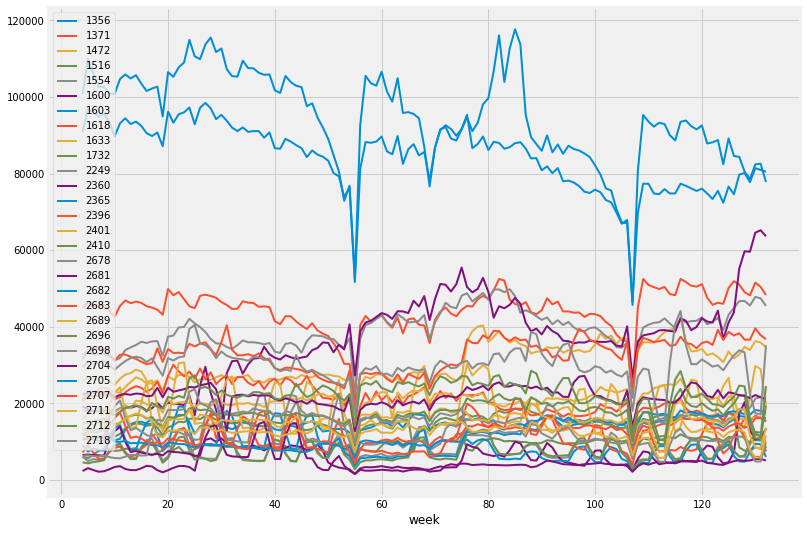

In [14]:
melt5=melt2.copy()
melt5.index=melt5.week
stocks = melt5[melt5.sku==1356].target.to_frame('1356')
skusss=[1371, 1472, 1516, 1554, 1600, 1603, 1618, 1633, 1732,2249, 2360, 2365, 2396, 2401, 2410, 2678, 2681, 2682, 2683, 2689,2696, 2698, 2704, 2705, 2707, 2711, 2712, 2718]
#skusss=[ 144,  546,  549,  554,  686,  688, 1027, 1035, 1051, 1058, 1065,1206, 1365, 1371, 1472, 1516, 1554, 1600, 1603, 1618, 1633,1732, 2249, 2360, 2365, 2396, 2401, 2410, 2678, 2681, 2682, 2683,2689, 2696, 2698, 2704, 2705, 2707, 2711, 2712, 2718]
for i in skusss:
    stocks = stocks.join(melt5[melt5.sku==i].target.to_frame('{}'.format(i)))


stocks.plot(figsize=figsize);

In [15]:
def ADFuller(df):
    index=df.index
    columns = df.columns
    df_stats = pd.DataFrame(columns=['p-value'], index=columns)
    for col in columns:
        df_stats.loc[col]=adfuller(df[col], autolag='AIC')[1]
    return df_stats
df_p=ADFuller(stocks)

In [16]:
#all the stationary products
df_p[df_p['p-value']<0.05].index

Index(['1356', '1371', '1516', '1603', '1633', '1732', '2249', '2396', '2401',
       '2410', '2689', '2704', '2718'],
      dtype='object')

In [17]:
melt2[np.isin(melt2["sku"],[1356, 1371, 1516, 1603, 1633, 1732, 2249, 2396, 2401,
       2410, 2704, 2718])]

,sku,week,target,price,sales w-1,sales w-3,w-1 diff,w-3 diff
12,1356,4,13101.0,1.25,7845.0,12083.0,-2414.0,-384.0
14,1371,4,44977.0,1.00,23008.0,31918.0,-6496.0,-651.0
16,1516,4,11972.0,0.95,6945.0,9482.0,-2350.0,-674.0
19,1603,4,100715.0,0.50,57619.0,76316.0,-18718.0,-3993.0
21,1633,4,15731.0,0.52,10074.0,16200.0,-5495.0,-617.0
22,1732,4,6057.0,1.25,4807.0,6603.0,-1932.0,236.0
23,2249,4,6095.0,1.79,6535.0,9618.0,-2573.0,1111.0
26,2396,4,7192.0,0.78,2398.0,3923.0,-1035.0,-1976.0
27,2401,4,13821.0,1.82,15463.0,22555.0,-5337.0,3388.0
28,2410,4,4625.0,1.83,5072.0,8641.0,-3146.0,1329.0


In [18]:
melt2=melt2[np.isin(melt2["sku"],[1356, 1371, 1516, 1603, 1633, 1732, 2249, 2396, 2401,
       2410, 2704, 2718])]

In [19]:
#baseline : predictions are sales from previous week(but now just with stationary products)
mapes = []
for week in range(109,132):
    train = melt2[melt2['week'] < week]
    val = melt2[melt2['week'] == week]

    p = val['sales w-1'].values

    error = mean_absolute_percentage_error(val['target'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mapes.append(error)
print('Mape = %.5f' % np.mean(mapes))

Week 109 - Error 11.75307
Week 110 - Error 1.90397
Week 111 - Error 16.84494
Week 112 - Error 11.89888
Week 113 - Error 1.41498
Week 114 - Error 18.15473
Week 115 - Error 11.44682
Week 116 - Error 6.99971
Week 117 - Error 14.26096
Week 118 - Error 8.31837
Week 119 - Error 1.45587
Week 120 - Error 14.85191
Week 121 - Error 15.57300
Week 122 - Error 1.83970
Week 123 - Error 14.53742
Week 124 - Error 10.50816
Week 125 - Error 10.12571
Week 126 - Error 14.98514
Week 127 - Error 21.61169
Week 128 - Error 6.82018
Week 129 - Error 20.10680
Week 130 - Error 12.72558
Week 131 - Error 1.96108
Mape = 10.87385


In [20]:
#Let's try to use just stationary products
mean_error = []
for week in range(109,132):
    print
    train = melt2[melt2['week'] < week]
    val = melt2[melt2['week'] == week]

    xtr, xts = train.drop(['target'], axis=1), val.drop(['target'], axis=1)
    ytr, yts = train['target'].values, val['target'].values

    mdl = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = mean_absolute_percentage_error(yts, p)
    print('Week %d - mape %.5f' % (week, error))
    mean_error.append(error)
print('Mape = %.5f' % np.mean(mean_error))

Week 109 - mape 17.56836
Week 110 - mape 13.07601
Week 111 - mape 13.84426
Week 112 - mape 13.46081
Week 113 - mape 8.16967
Week 114 - mape 7.52999
Week 115 - mape 7.02007
Week 116 - mape 8.01598
Week 117 - mape 5.65118
Week 118 - mape 4.26320
Week 119 - mape 3.75769
Week 120 - mape 5.23857
Week 121 - mape 5.50701
Week 122 - mape 3.04343
Week 123 - mape 5.87528
Week 124 - mape 9.79470
Week 125 - mape 10.33025
Week 126 - mape 4.17922
Week 127 - mape 16.86141
Week 128 - mape 14.59148
Week 129 - mape 16.88059
Week 130 - mape 16.36797
Week 131 - mape 6.71224
Mape = 9.46693
